# Bayesian Gaussian Mixture Modeling using TensorFlow Probability

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.compat.v1.enable_eager_execution()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  
TensorFlow version: 1.15.0-dev20190821
TensorFlow Probability version: 0.8.0-dev20190828


## Generate some data

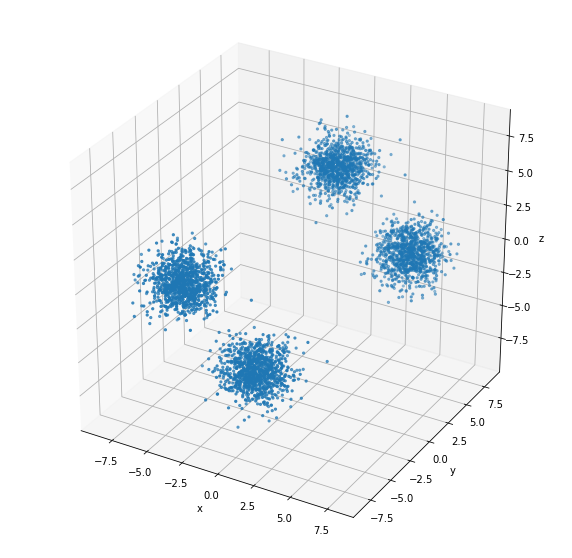

In [2]:
n_samples_per_component = 1000
n_dims = 3
n_components = 4
n_samples = n_samples_per_component * n_components

X = np.random.randn(n_samples, n_dims).astype('float32')  # assume identity covariance matrix

X[:n_samples_per_component, :] += [5, 5, 0]
X[n_samples_per_component:2 * n_samples_per_component, :] += [-5, -5, 0]
X[2 * n_samples_per_component:3 * n_samples_per_component, :] += [0, 5, 5]
X[3 * n_samples_per_component:, :] += [0, -5, -5]

# Plot the data
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(X[:, :1], X[:, 1:2], X[:, 2:], marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Make a TensorFlow Dataset from that data

In [3]:
batch_size = 500
dataset = tf.data.Dataset.from_tensor_slices((X)).shuffle(10000).batch(batch_size)

## Build a Gaussian Mixture Model via model subclassing

In [4]:
class GaussianMixtureModel(tf.keras.Model):
    """A Bayesian Gaussian mixture model.
    
    Assumes Gaussians' variances in each dimension are independent.
    
    Parameters
    ----------
    n_components : int > 0
        Number of mixture components.
    n_dims : int > 0
        Number of dimensions.
    """
    def __init__(self, n_components, n_dims):
        # Initialize
        super(GaussianMixtureModel, self).__init__()
        self.n_components = n_components
        self.n_dims = n_dims
        
        # Variational posterior distribution variables for variances
        self.alpha = tf.Variable(tf.random.uniform((n_components, n_dims), 0.4, 0.6), name='alpha',
                                 constraint=lambda x: tf.clip_by_value(x, 1e-7, np.infty))  # non-negative
        self.beta = tf.Variable(tf.random.uniform((n_components, n_dims), 0.4, 0.6), name='beta',
                                constraint=lambda x: tf.clip_by_value(x, 1e-7, np.infty))  # non-negative
        
        # Variational posterior distribution variables for means
        self.mu = tf.Variable(tf.random.normal((n_components, n_dims)), name='mu')
        self.v = tf.Variable(tf.random.uniform((n_components, n_dims), 0.9, 1.1), name='v',
                             constraint=lambda x: tf.clip_by_value(x, 1e-7, np.infty))  # non-negative
        
        # Variational posterior distribution variables for component weights
        self.counts = tf.Variable(2 * tf.ones((n_components,)), name='counts',
                                  constraint=lambda x: tf.clip_by_value(x, 1e-7, np.infty))  # non-negative

        # Prior distributions for the inverse variances
        self.invvar_prior = tfd.Gamma(concentration=0.5 * tf.ones((n_components, n_dims)),
                                      rate=0.5 * tf.ones((n_components, n_dims)),
                                      validate_args=True, allow_nan_stats=False)
        
        # Prior distributions for the means
        self.mu_prior = tfd.Normal(loc=tf.zeros((n_components, n_dims)),
                                   scale=1 / tf.sqrt(self.invvar_prior.sample(1)[0]),
                                   validate_args=True, allow_nan_stats=False)
        
        # Prior distributions for the component weights
        self.theta_prior = tfd.Dirichlet(concentration=2 * tf.ones((n_components,)),
                                         validate_args=True, allow_nan_stats=False)
        
    def call(self, x, sampling=True):
        """Compute losses given a batch of data.
        
        Parameters
        ----------
        x : tf.Tensor
            A batch of data
        sampling : bool
            Whether to sample from the variational posterior
            distributions (if True, the default), or just use the
            mean of the variational distributions (if False).
            
        Returns
        -------
        log_likelihoods : tf.Tensor
            Log likelihood for each sample
        kl_sum : tf.Tensor
            Sum of the KL divergences between the variational
            distributions and their priors
        """
        
        # The variational distributions
        invvar = tfd.Gamma(concentration=self.alpha,
                           rate=self.beta,
                           validate_args=True, allow_nan_stats=False)  # sigma^{-2}
        mu = tfd.Normal(loc=self.mu,
                        scale=tf.sqrt(self.v / invvar.sample(1)[0]),
                        validate_args=True, allow_nan_stats=False)
        theta = tfd.Dirichlet(concentration=self.counts,
                              validate_args=True, allow_nan_stats=False)
        
        # Sample from the variational distributions
        if sampling:
            batch_size = x.shape[0] # number of samples in the batch
            mu_sample = mu.sample(batch_size)
            sigma_sample = 1 / tf.sqrt(invvar.sample(batch_size))
            theta_sample = theta.sample(batch_size)
        else:
            mu_sample = tf.reshape(mu.mean(), (1, self.n_components, self.n_dims))
            sigma_sample = 1 / tf.sqrt(tf.reshape(invvar.mean(), (1, self.n_components, self.n_dims)))
            theta_sample = tf.reshape(theta.mean(), (1, self.n_components))
        
        # The mixture density
        density = tfd.Mixture(cat=tfd.Categorical(probs=theta_sample),
                              components=[tfd.MultivariateNormalDiag(loc=mu_sample[:, i, :],
                                                                     scale_diag=sigma_sample[:, i, :]) 
                                          for i in range(self.n_components)])
                
        # Compute the mean log likelihood
        log_likelihoods = density.log_prob(x)
        
        # Compute the KL divergence sum
        div_invvar = tf.reduce_sum(tfd.kl_divergence(invvar, self.invvar_prior))
        div_mu = tf.reduce_sum(tfd.kl_divergence(mu, self.mu_prior))
        div_theta = tf.reduce_sum(tfd.kl_divergence(theta, self.theta_prior))
        kl_sum = div_invvar + div_mu + div_theta
        
        # Return both losses
        return log_likelihoods, kl_sum
    
# model instantiation
model = GaussianMixtureModel(n_components, n_dims)

## Model fitting

In [5]:
lr = 2e-3
optimizer = tf.keras.optimizers.Adam(lr=lr)

loss_nll = tf.keras.metrics.Mean(name='negative_log_likelihoods')
loss_kl = tf.keras.metrics.Mean(name='KL_divergence')
loss_train = tf.keras.metrics.Mean(name='loss_train')

@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        log_likelihoods, kl_sum = model(data)
        neg_elbo = kl_sum/n_samples - tf.reduce_mean(log_likelihoods)
    tvars = model.trainable_variables
    gradients = tape.gradient(neg_elbo, tvars)
    optimizer.apply_gradients(zip(gradients, tvars))
    # record metrics
    loss_nll(-tf.reduce_mean(log_likelihoods))
    loss_kl(kl_sum)
    loss_train(neg_elbo)
    
# Fit the model
n_epochs = 5000
n_epochs_per_print = 50
for epoch in range(n_epochs):
    for data in dataset:
        train_step(data)
    if (epoch + 1) % n_epochs_per_print == 0:
        print('Epoch {}: nll = {:.4f}, kl = {:.4f}, -elbo = {:.4f}'.format(epoch+1,
                                                                           loss_nll.result(),
                                                                           loss_kl.result(),
                                                                           loss_train.result()))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 50: nll = 14.5297, kl = 64827.4336, -elbo = 30.7366
Epoch 100: nll = 13.8960, kl = 42066.7461, -elbo = 24.4127
Epoch 150: nll = 13.3934, kl = 31213.6172, -elbo = 21.1968
Epoch 200: nll = 12.9728, kl = 115586.2188, -elbo = 41.8693
Epoch 250: nll = 12.6305, kl = 92916.9844, -elbo = 35.8598
Epoch 300: nll = 12.3094, kl = 78515.9922, -elbo = 31.9384
Epoch 350: nll = 12.0162, kl = 139898.2812, -elbo = 46.9908
Epoch 400: nll = 11.7452, kl = 123646.8203, -elbo = 42.6569
Epoch 450: nll = 11.4992, kl = 110338.4609, -elbo = 39.0837
Epoch 500: nll = 11.2798, kl = 99618.2578, -elbo = 36.1844
Epoch 550: nll = 11.0793, kl = 90861.7891, -elbo = 33.7948
Epoch 600: nll = 10.8959, kl = 83586.0000, -elbo = 31.7925
Epoch 650: nll = 10.7282, kl = 79204.4531, -elbo = 30.5294
Epoch 700: nll = 10.5761, kl = 74031.5938, -elbo = 29.0841
Epoch 750: nll = 10.4485, kl = 69196.7812, -elbo = 27.7479
Epoch 800: nll = 1

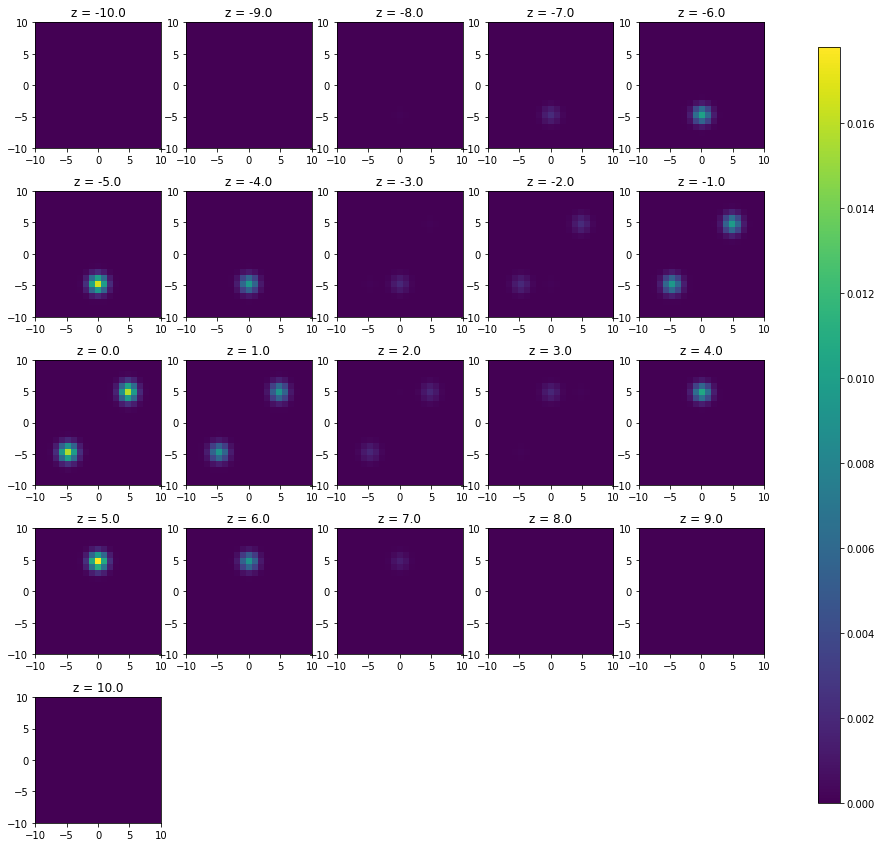

In [6]:
# Compute log likelihood at each point on a grid
n_grids = 21 # number of grid points
x_, y_, z_ = np.linspace(-10, 10, n_grids), np.linspace(-10, 10, n_grids), np.linspace(-10, 10, n_grids)
x_grid, y_grid, z_grid = np.meshgrid(x_, y_, z_)
grids = np.column_stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()])
ll, _ = model(grids.astype('float32'), sampling=False)
ll = np.reshape(ll, (n_grids, n_grids, n_grids))
        
# Show the fit mixture density (slices of z-axis)
n_subplot_rows = 5
fig, ax = plt.subplots(n_subplot_rows, n_grids // n_subplot_rows + 1, figsize=(15, 15))
for i in range(n_subplot_rows):
    for j in range(n_grids // n_subplot_rows + 1):
        idx = i * (n_grids // n_subplot_rows + 1) + j
        if idx < n_grids:
            im = ax[i, j].imshow(np.exp(ll)[:, :, idx], extent=(-10, 10, -10, 10), origin='lower',
                                 vmin=0, vmax=np.exp(ll).max())
            ax[i, j].title.set_text('z = {}'.format(z_[idx]))
        else:
            ax[i, j].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Output trainable variables

In [7]:
{v.name: v.numpy() for v in model.trainable_variables}

{'alpha:0': array([[ 7.6340585, 11.578477 , 11.309826 ],
        [14.755032 ,  8.476629 , 11.869498 ],
        [13.095087 ,  6.914214 , 12.226909 ],
        [13.564029 , 13.127159 , 10.947091 ]], dtype=float32),
 'beta:0': array([[ 7.160009 , 12.602536 , 11.034424 ],
        [15.392021 ,  8.636125 , 11.492381 ],
        [13.042036 ,  6.5155396, 10.320694 ],
        [13.595955 , 12.3736725, 10.564042 ]], dtype=float32),
 'mu:0': array([[ 5.0364656e+00,  5.0320878e+00, -3.2063186e-02],
        [-4.9949656e+00, -5.0545807e+00, -1.5291735e-02],
        [ 3.9055040e-03,  4.9422231e+00,  4.9374437e+00],
        [-2.3706404e-02, -4.9660234e+00, -5.0293059e+00]], dtype=float32),
 'v:0': array([[0.05258741, 0.03006832, 0.03263875],
        [0.00144147, 0.0549627 , 0.00081457],
        [0.06013688, 0.00287003, 0.00135099],
        [0.00162616, 0.05527586, 0.01388463]], dtype=float32),
 'counts:0': array([23.706099, 23.874805, 23.851171, 23.826368], dtype=float32)}

## Pairwise plot

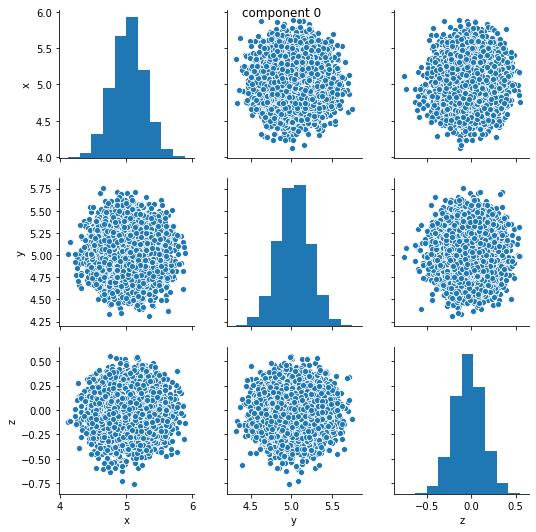

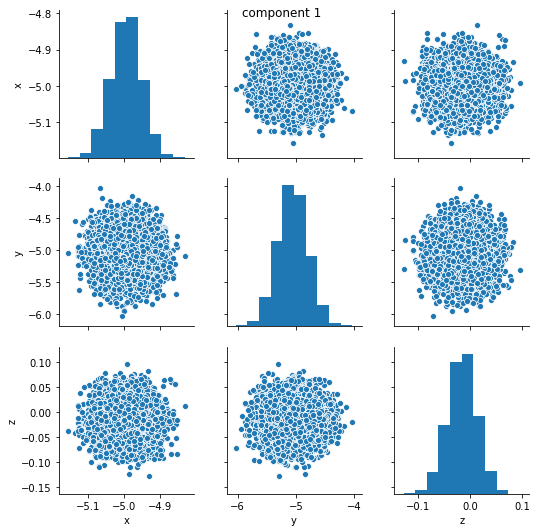

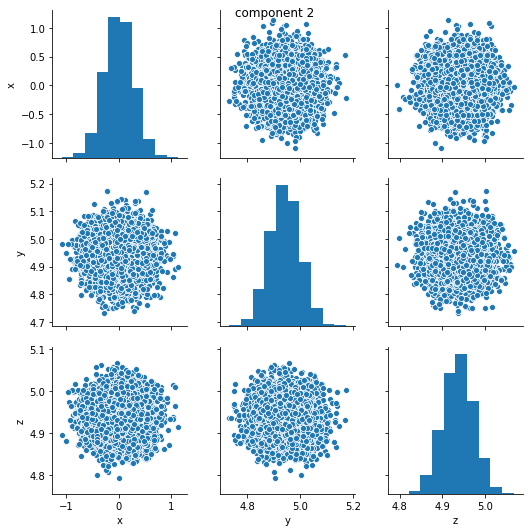

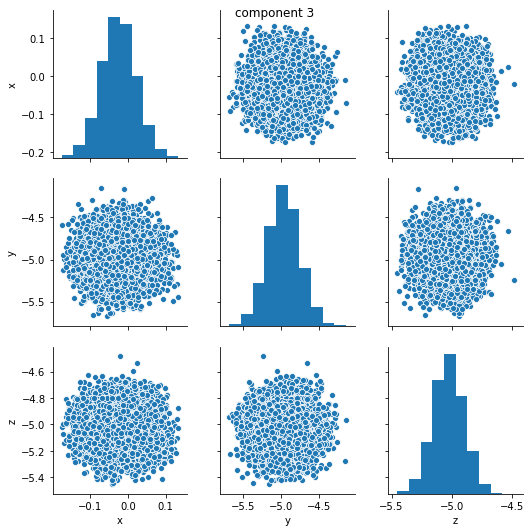

In [8]:
invvar = tfd.Gamma(concentration=model.alpha,
                   rate=model.beta,
                   validate_args=True, allow_nan_stats=False)  # sigma^{-2}
mu = tfd.Normal(loc=model.mu,
                scale=tf.sqrt(model.v / invvar.sample(1)[0]))
mu_samples = mu.sample(10000)
for c in range(n_components):
    mu_dataset = pd.DataFrame({'x': mu_samples.numpy()[:, c, 0],
                               'y': mu_samples.numpy()[:, c, 1],
                               'z': mu_samples.numpy()[:, c, 2]})
    fig_sns = sns.pairplot(mu_dataset)
    fig_sns.fig.suptitle('component {}'.format(c))